In [86]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
# global variable for setting the torch.load    map_location
if torch.cuda.is_available():
    loadmap = {'cuda:0': 'gpu'}
else:
    loadmap = {'cuda:0': 'cpu'}

%load_ext autoreload
%autoreload 2 # Reload modules before executing a cell

import matplotlib.pyplot as plt
import pandas as pd
import datetime
from tqdm import tqdm_notebook as tqdm
import seaborn as sb

### Import our modules
import utils
import statistical_tests as test
from GAN import GAN as gan

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Using GAN to generate Financial Time Series

## Reproducing the distribution of the VIX Index

We will first try to implement a GAN that will be able to generate time series that have the same properties as the CBOE VIX Index. Indeed the VIX has some interesting properties that are hard to replicate with standard model, due to the nature of the Index (which replicates the Volatility of the American Stock Market). To make the series stationary we consider the Log-returns of the distribution. In particular, we are interested in building a generator capable of:
* Sample from the "normal mode" of the Log-return of the series, that we could approximate as a Gaussian mode
* Sample recurring spikes, that are visible both on the raw Time Series and on its Log-returns

There is no simple tool to draw such distribution. In other projects we studied for instance Hidden Markov Models. This kind of model can be used if we consider the time series as a Markov Chain and if we make prior assumptions on the number of states (here we would intuitively set a "normal" state and a "peaky" state, or "normal/positive peak/negative peaks" state), and on the distribution of the log-returns in each state. We did not try such model here, but that would definitely be our approach if we would like to try more classical inference-based methods on this problem.

On the contrary, we are going to try some Generative Adversarial Networks architectures to solve this problem. Our hope is that every architecture uses its properties to capture relevant behaviours in the time series in order to be able to draw samples from a distribution that is as close as possible to the true one. For our experiments we implemented most function in \textit{.py} files in order to make this notebook easier to read. 

### Download the VIX Index between 2014 and 2019

First of all, we found an online source to download the Time Series of the VIX Index. We choose to start from 2014 in order to avoid using data from the different crisis periods that occured in the past years. The Series is composed of around 1200 points, which would be enough to make statistical inference but may be light to build train samples for a deep learning model. We will see later what we imagined to circumvent this problem.

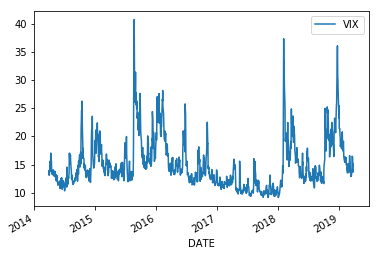

In [4]:
VIX_raw = pd.read_csv('VIX.csv', index_col=0, parse_dates=True, dayfirst=True)
VIX_raw.iloc[:, 0] = VIX.iloc[:, 0].astype('float')
VIX_raw.plot()

We want to make the serie stationary by taking its log-returns:

$$
X_t = \text{log}(\frac{VIX_t}{VIX_{t-1}})
$$

The advantage of the log-returns is that the return between two dates $t0$ and $t1$ is the sum of the returns on every subdivision between these date. Hence, it is quite easy to recompose the actual price of the Index from its returns:
$$
\text{log}(\frac{VIX_{t_1}}{VIX_{t_0}}) = \text{log}(\prod_{i=0}^{n-1}\frac{VIX_{t(\frac{i+1}{n})}}{VIX_{t(\frac{i}{n})}}) 
$$
For any increasing sequence of times $t(0)=t_0, t_(\frac{1}{n}),..., t_(\frac{n-1}{n}), t(1)=t_1$.

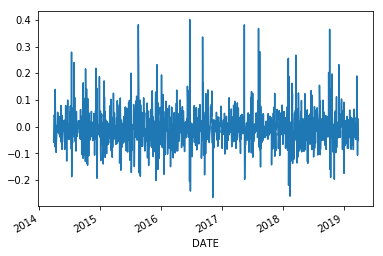

In [5]:
utils.get_data('VIX.csv', array=False).plot()

### Basic analysis of the distribution of the Log-return Series

We have a first look at the global distribution of the Series:

C:\Users\dobau\Anaconda3\envs\py36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


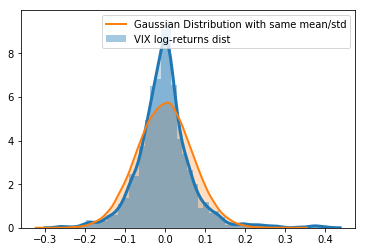

In [13]:
VIX = utils.get_data('VIX.csv')
m, sd = VIX.mean(), VIX.std()
sb.distplot(VIX, hist=True, kde=True, label='VIX log-returns dist', 
            kde_kws = {'shade': True, 'linewidth': 3})
sample = np.random.normal(m, sd, size=100000)
sb.distplot(sample, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2}, 
                  label = 'Gaussian Distribution with same mean/std')

We see that the distribution is clearly not gaussian, not symmetric (skewed), and leptokurtic (fat tails compared with the Gaussian). This is enough to prove the point that a Gaussian approximation would definitely fail to reproduce the properties of this distribution. 

But now we can try the same by removing the outliers. For this we simply apply a basic filter based on the standard deviation of the model.

1115 Filtered data out of 1258 original data


C:\Users\dobau\Anaconda3\envs\py36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


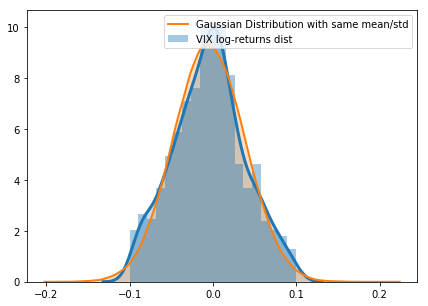

In [37]:
VIX_normal_regime = VIX[np.where(np.abs(VIX) < 0.1)]
new_mean, new_sd = VIX_normal_regime.mean(), VIX_normal_regime.std()
print('%i Filtered data out of %i original data' % (len(VIX_normal_regime), len(VIX)))
plt.figure(figsize=(7, 5))
sb.distplot(VIX_normal_regime, hist=True, kde=True, label='VIX log-returns dist', 
            kde_kws = {'shade': True, 'linewidth': 3})
sample = np.random.normal(new_mean, new_sd, size=100000)
sb.distplot(sample, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2}, 
                  label = 'Gaussian Distribution with same mean/std')

It is quite impressive to see how removing only around $10\%$ of the data makes the new distribution very close to a Gaussian distribution. We provide QQ-plots to compare these distributions' quantiles with the ones of the Gaussian distribution. There are of course border effects for the filtered distribution, but the quantiles are much closer to the identity curve otherwise.

VIX Log-returns QQ-plot


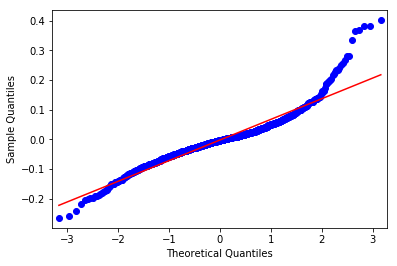

Filtered log-returns QQ-plot


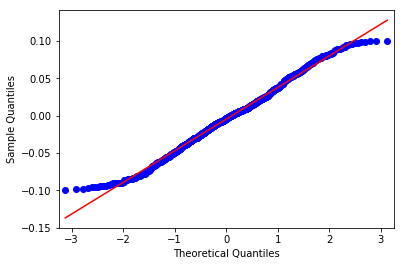

In [52]:
from statsmodels.graphics.gofplots import qqplot
print('VIX Log-returns QQ-plot')
qqplot(VIX, line='s')
plt.show()
print('Filtered log-returns QQ-plot')
qqplot(VIX_normal_regime, line='s')
plt.show()

Now we are interested in the distribution of the negative and positive peaks. As there are much fewer points it is harder to make a good asumption, but with the figures below we suggest to either consider these peaks as shifted exponential distribution, or as Gamma distribution (to attenuate the impact of the choice of the threshold).

C:\Users\dobau\Anaconda3\envs\py36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


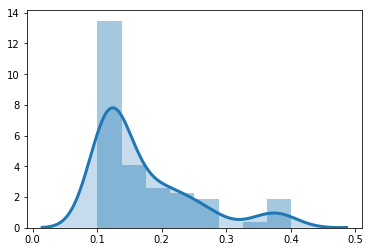

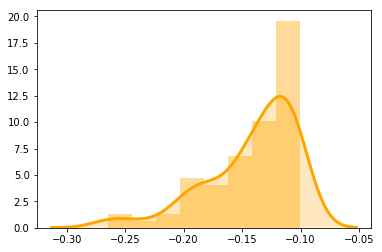

In [58]:
peaky_VIX = VIX[np.where(np.abs(VIX) > 0.1)]
sb.distplot(peaky_VIX[peaky_VIX>0], hist=True, kde=True, label='VIX log-returns dist on positive peaks', 
            kde_kws = {'shade': True, 'linewidth': 3})
plt.show()
sb.distplot(peaky_VIX[peaky_VIX<0], hist=True, kde=True, label='VIX log-returns dist on negative peaks', 
            kde_kws = {'shade': True, 'linewidth': 3}, color='orange')

This little study is primordial in our opinion because we strongly that before applying complex deep learning models it is necessary to have a good understanding of the data at hand, and what we are looking to do. Our last analysis in this part is to check the adequacy of the VIX time series with the styized facts about financial time series we detail in our pdf report.  
The facts we check below are:
* Stationarity of the Return Series (the raw Series is clearly non stationay so we don't check it)
* Uncorrelation of the Log-returns
* Autocorrelation of squared Log-returns
* Skewness and Leptokurticity

In [76]:
print('Stationarity Test for returns')
test.is_stationnary(VIX, '5%', display_stats=True)
print('__________________________________')
print(' ')
print('Autocorrelation Test on Log-returns')
test.check_autocorel(VIX, 10, 0.05,
                              qstat=True, score_min=0.8, display_stats=True)
print('__________________________________')
print(' ')
print('Autocorrelation Test on squared Log-returns')

test.check_autocorel(VIX**2, 10, 0.05,
                              qstat=True, score_min=0.8, display_stats=True)
print('__________________________________')
print(' ')
print('Computation of the moments of log-returns')
test.get_moments(VIX)

Stationarity Test for returns
ADF Statistic: -11.715874
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
__________________________________
 
Autocorrelation Test on Log-returns
Autocorrelations: [ 1.         -0.0220979  -0.0447664  -0.0027459  -0.05583679 -0.04933308
 -0.05925662 -0.0252395  -0.04346091 -0.0364005   0.02391487]
Confidence intervals: [[ 1.00000000e+00  1.00000000e+00]
 [-7.73575083e-02  3.31617003e-02]
 [-1.00052981e-01  1.05201825e-02]
 [-5.81430586e-02  5.26512598e-02]
 [-1.11234368e-01 -4.39218054e-04]
 [-1.04902242e-01  6.23608852e-03]
 [-1.14959360e-01 -3.55387241e-03]
 [-8.11344048e-02  3.06554042e-02]
 [-9.93906100e-02  1.24687814e-02]
 [-9.24332266e-02  1.96322282e-02]
 [-3.21900204e-02  8.00197586e-02]]
Q stats of Ljung Box test: [ 0.61576936  3.14486863  3.1543917   7.09528413 10.17404901 14.6195484
 15.4267005  17.82188455 19.50340993 20.22980454]
p-values: [0.43262378 0.20753935 0.3684281  0.13093776 0.0704512  0.02343139
 0.03090255 

(-0.0025205029265861064,
 0.06962744234835493,
 0.9320535918979757,
 5.157252114548843)

Our stationarity test is an Augmented Dickey Fuller test. The null hypothesis that there is a unique root in the time series is strongly rejected here, so the hypothesis stationarity is not rejected by this test.

The autocorrelation is trickier to analyze because results are often quite unstable with this kind of test. However, our results seem to be in favour of the stylized facts. Indeed even if the non-autocorrelation cannot be rejected at a $5\%$ confidence level for every term, it is at a $1\%$ condidence level. And we see that when they are value 0 is always on the confidence interval or one of the boundaries is really small. For this reason, we would interpret these results as a good indicator that the returns are uncorrelated. On the other hand, for the squared returns the null hpyothesis (stating that a coefficient is 0) is strongly rejected at each time window.

To conclude this analysis by the moments: we verify that the Log-return Series has a positive skewness ($0.93$) and is clearly leptokurtic: its kurtosis is 5 points in excess of the Normal distribution kurtosis (which is 3).


Now that we verified  these facts, we can use the test we implemented as another base to evaluate our different generating models. We can now skip to the Deep Learning part of our project with the experimental setup for training our GAN models.

## Implementation of Generative Adversarial Networks

### Batch generator

The first task is to determine a way to draw training samples from our real distribution. This is not an easy task because of the limited amount of available data (1200 in our case), as we want to both get realistic and diverse samples.

To tackle this problem, our first idea is to focus on the problem of generating sequences of a given length. Our base windows are 60, 125 and 250 days, which roughly correspond to 3 months, 6 months and a year in terms of trading days. Then, an intuitive idea to draw sample is to randomly choose a start and a sequence of the right length from this point. This idea is able to provide a reasonable sample size. 

However, the given samples may lack some diversity as there are only a few peaks available in the whole sequences (we before considered around 100 points as peaks). As we do not want our network to learn exactly the value of the peaks, we mays want to add some diversity in the sample. To achieve this, we can use "Data Augmentation" methods. We used the simplest one in practice: adding some noise into real samples. The noise needs to be calibrated in order to keep the data structure, i.e it has to be small compared with the real standard deviation. A more precise method could be to keep the separation of the Series in three states as before, and add a different kind of noise for each state. Hence we could preserve the separation between peaks and normal data.

A last idea could be to completely guide the model by training the model with mixed real/generated samples. The samples could be drawn from a simple statistical model. In our case we could calibrate a simple mixture of Gaussian distributions for the normal state and two Gamma distributions for the peaky states. Unfortunately we did not have enough time to implement these methods. We can also add that this simple generator could also be a benchmark for our more complex algorithms!

In the next cell we just plot a batch generated with the method described above for a window of 125 days.

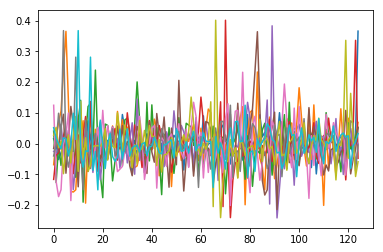

In [78]:
batch = utils.generate_batch(VIX, 125, 10)
plt.plot(batch.numpy().T)

## GAN

In our code we implemented different kinds of GAN architectures, with blocks composed for instance of:
* Fully connected layers 
* Convolutional layers
* LSTM layers
We tried to generally get the same kind of architecture for the Generator and the Discriminator (and not combine a convolutional generator and a LSTM discriminator for example, which would make little sense). The interested reader may refer directly to our source code files to get a deeper overview of our architectures. We show on the cell below the training of a GAN using fully connected layers for the generator and the discriminator.

step 0: discriminator: 1.385e+02, generator: -6.836e+01


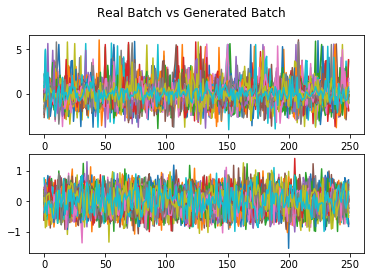

step 50: discriminator: 1.232e+02, generator: -6.192e+01
step 100: discriminator: 1.296e+02, generator: -6.434e+01


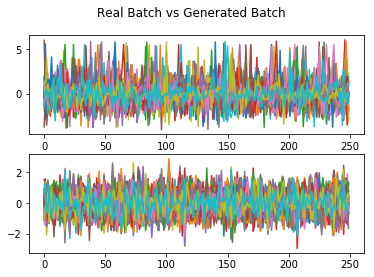

step 150: discriminator: 1.305e+02, generator: -6.394e+01
step 200: discriminator: 1.336e+02, generator: -6.738e+01


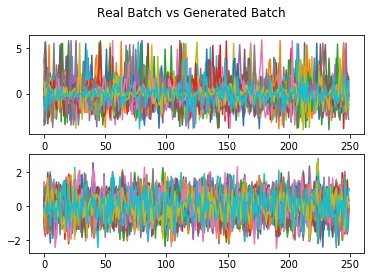

step 250: discriminator: 1.360e+02, generator: -6.772e+01
step 300: discriminator: 1.372e+02, generator: -6.820e+01


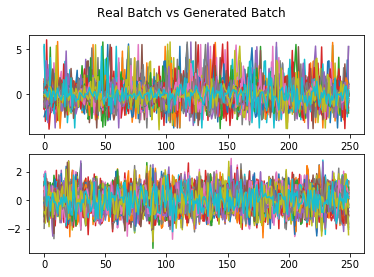

step 350: discriminator: 1.382e+02, generator: -6.984e+01
step 400: discriminator: 1.385e+02, generator: -6.906e+01


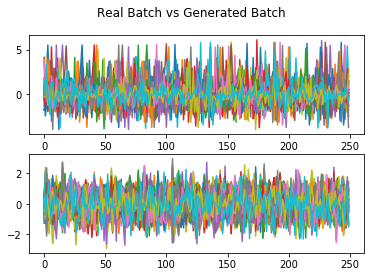

TypeError: 'NoneType' object is not iterable

In [87]:
from Lin_GAN import *
from Lin_GAN import Generator as LG
from Lin_GAN import Discriminator as LD

param = {
    'serie': VIX,
    'window': 250,
    'frame': 50,
    # Display options
    'frame_plot': 100,
    'is_notebook': True,
    'batchlen_plot': 50,
    'plot': True,
    # Base class of the Generator and Discriminator
    'Generator': Generator,
    'Discriminator': Discriminator,
    # Training parameters
    'N_ITER': 1001,
    'TRAIN_RATIO': 5,
    'BATCHLEN': 100,
    'generator_args': {
    # Random Noise used by the Generator
    'PRIOR_N': 20,
    'PRIOR_STD': 1.,
    # Depth and Withdraw of Hidden Layers
    'WDTH': 1000, 
    'DPTH': 10},
    'discriminator_args': {
    # Depth and Withdraw of Hidden Layers
    'WDTH': 100,
    'DPTH': 5},
    # Adam Optimizer parameters for Generator/Discriminator
    'lr_G': 1e-4,
    'betas_G': (0.5, 0.9),
    'lr_D': 1e-4,
    'betas_D': (0.5, 0.9),
    # Stopping/Saving options
    'time_max': 1200,
    'save_model': False,
    'save_name': 'Lin_G_'+str(int(np.random.uniform()*1e9))
}

G, D = gan(**param)

# Pre-Trained models

{'serie': array([-0.05783672, -0.00076365,  0.02116481, ...,  0.03151451,
       -0.04869116, -0.05118388]), 'window': 60, 'frame': 500, 'frame_plot': 200, 'is_notebook': False, 'batchlen_plot': 10, 'Generator': <class 'Lin_GAN.Generator'>, 'Discriminator': <class 'Lin_GAN.Discriminator'>, 'save_model': True, 'save_name': 'Lin_G_581130543', 'plot': False, 'N_ITER': 2001, 'TRAIN_RATIO': 10, 'BATCHLEN': 100, 'generator_args': {'PRIOR_N': 1, 'PRIOR_STD': 1.0, 'WDTH': 10, 'DPTH': 3}, 'discriminator_args': {'WDTH': 1000, 'DPTH': 10}, 'lr_G': 0.0001, 'betas_G': (0.5, 0.9), 'lr_D': 0.0001, 'betas_D': (0.5, 0.9)}


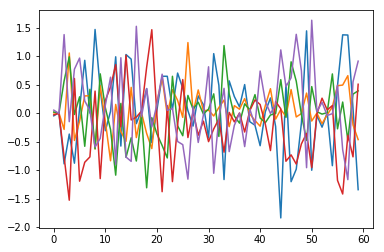

In [9]:
from Lin_GAN import *
from Lin_GAN import Generator as LG
from Lin_GAN import Discriminator as LD
name = 'Lin_G_581130543'
G, D, param_name = utils.load_models(name, LG, LD)
print(param_name)
plt.plot(G.generate(5).detach().numpy().T)
plt.show()

In [207]:
import os
available_param = os.listdir('Parameters')
name_list = []
for x in available_param:
    name_list.append(x[:-3])

In [208]:
gen = {}
param = {}
disc = {}
for name in tqdm(name_list):
    try:
        G, D, param_name = utils.load_models(name, LG, LD)
        gen[name] = G
        disc[name] = D
        param[name] = param_name
    except:
        print('file {} not found'.format(name))
        pass

file CG_241247271 not found
file CG_495999299 not found
file CG_627409447 not found
file Lin_G_173909855 not found
file Lin_G_828670679 not found
file RGAN_3971623 not found
file RGAN_775888731 not found



In [209]:
name_window = {'3M': [], '6M': [], 'Y': []}
for name in param.keys():
    wdw = param[name]['window']
    if wdw == 60:
        name_window['3M'].append(name)
    elif wdw == 125:
        name_window['6M'].append(name)
    elif wdw == 250:
        name_window['Y'].append(name)
    else:
        print('Unexpected window: {}'.format(wdw))
print([(key, len(name_window[key])) for key in name_window.keys()])

[('3M', 180), ('6M', 173), ('Y', 145)]


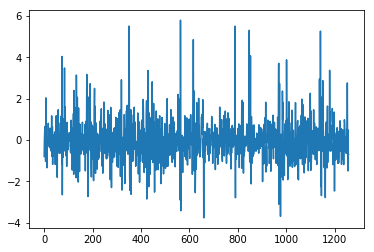

In [210]:
data = get_data('VIX.csv')
data = (data - data.mean())/data.std()
plt.plot(data)
plt.show()

In [211]:
n0, l0 = utils.get_KL_div_list(data, '3M', 100, name_window, LG, LD)
n1, l1 = utils.get_KL_div_list(data, '6M', 100, name_window, LG, LD)
n2, l2 = utils.get_KL_div_list(data, 'Y', 100, name_window, LG, LD)


 75%|████████████████████████████████████████████████████████████                    | 135/180 [00:50<00:12,  3.53it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [01:05<00:00,  3.37it/s]

 52%|██████████████████████████████████████████▏                                      | 90/173 [01:44<01:37,  1.18s/it]


100%|████████████████████████████████████████████████████████████████████████████████| 173/173 [03:35<00:00,  1.59s/it]

 36%|█████████████████████████████                                                    | 52/145 [02:50<05:07,  3.31s/it]


100%|████████████████████████████████████████████████████████████████████████████████| 145/145 [07:49<00:00,  3.11s/it]


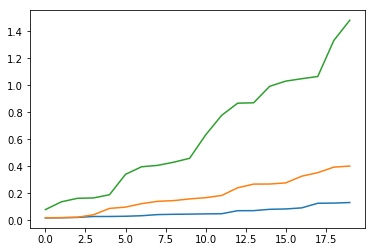

In [212]:
order_60 = np.argsort(l0)
order_125 = np.argsort(l1)
order_250 = np.argsort(l2)
plt.plot(np.sort(l0)[:20])
plt.plot(np.sort(l1)[:20])
plt.plot(np.sort(l2)[:20])

{'serie': array([-0.05783672, -0.00076365,  0.02116481, ...,  0.03151451,
       -0.04869116, -0.05118388]), 'window': 60, 'frame': 20, 'frame_plot': 50, 'is_notebook': False, 'batchlen_plot': 100, 'Generator': <class 'DCGAN.Generator'>, 'Discriminator': <class 'DCGAN.Discriminator'>, 'N_ITER': 500, 'TRAIN_RATIO': 3, 'BATCHLEN': 30, 'generator_args': {'PRIOR_N': 50, 'PRIOR_STD': 20.0, 'WDTH': 500, 'DPTH': 3}, 'discriminator_args': {'WDTH': 50, 'DPTH': 5}, 'lr_G': 0.0001, 'betas_G': (0.5, 0.9), 'lr_D': 0.0001, 'betas_D': (0.5, 0.9), 'time_max': 600, 'save_model': True, 'save_name': 'Lin_G_272220552', 'plot': False}


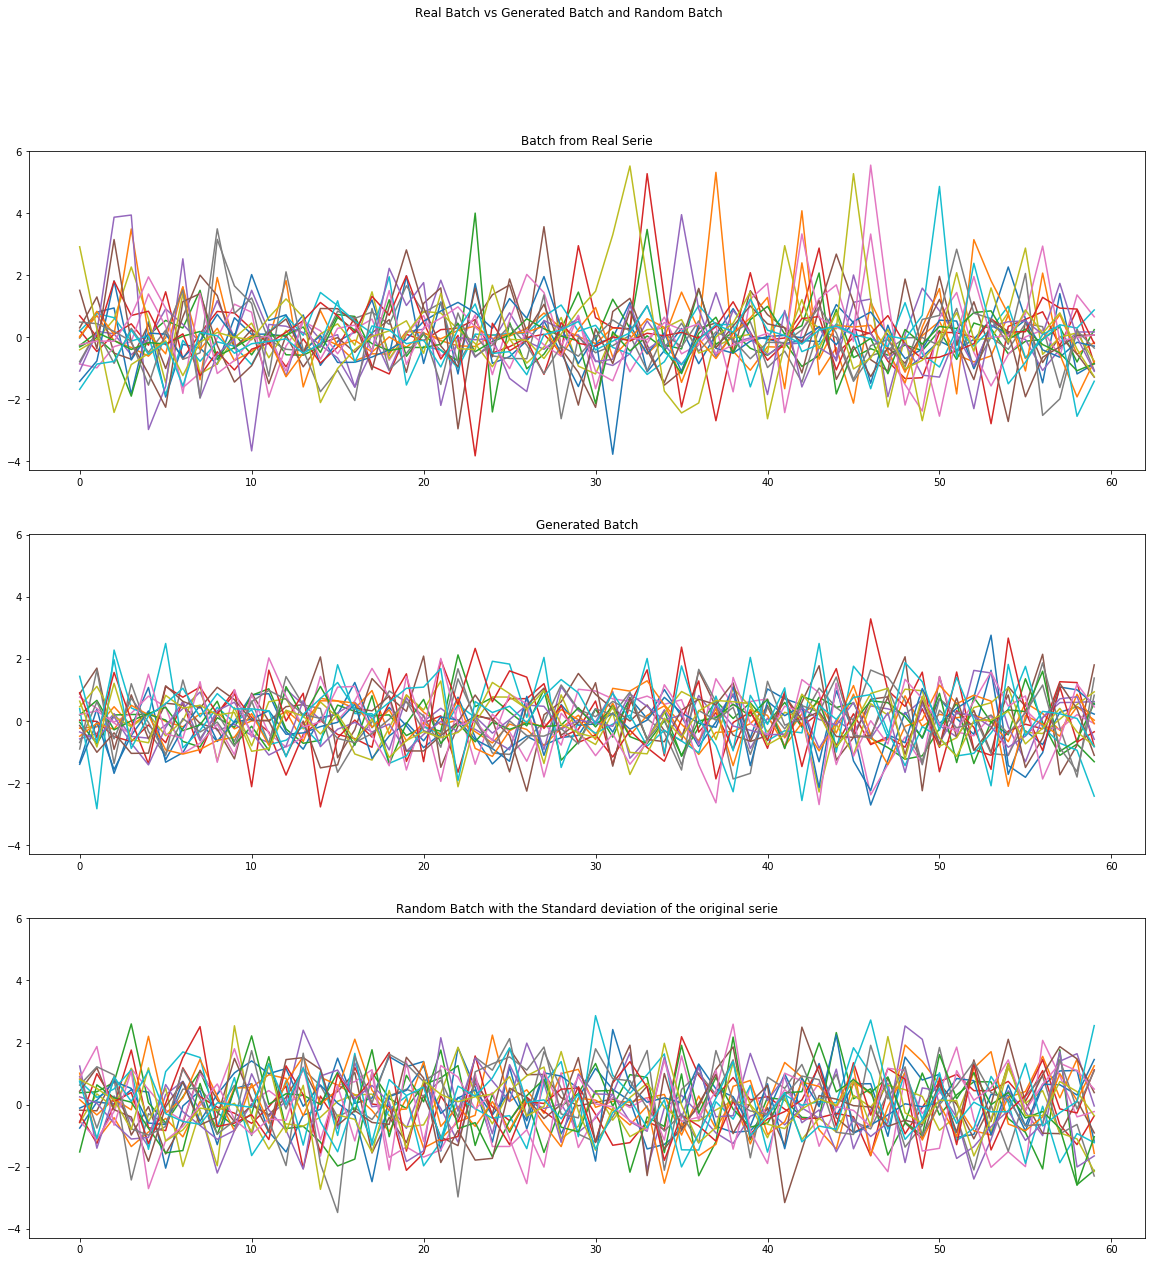

In [261]:
name_best = n0[order_60[50]]
utils.compare_plots(name_best, data, 20, 60, LG, LD)

{'serie': array([-0.05783672, -0.00076365,  0.02116481, ...,  0.03151451,
       -0.04869116, -0.05118388]), 'window': 125, 'frame': 20, 'frame_plot': 50, 'is_notebook': False, 'batchlen_plot': 100, 'Generator': <class 'DCGAN.Generator'>, 'Discriminator': <class 'DCGAN.Discriminator'>, 'N_ITER': 500, 'TRAIN_RATIO': 1, 'BATCHLEN': 10, 'generator_args': {'PRIOR_N': 10, 'PRIOR_STD': 10.0, 'WDTH': 1000, 'DPTH': 20}, 'discriminator_args': {'WDTH': 50, 'DPTH': 2}, 'lr_G': 0.0001, 'betas_G': (0.5, 0.9), 'lr_D': 0.0001, 'betas_D': (0.5, 0.9), 'time_max': 600, 'save_model': True, 'save_name': 'Lin_G_303541266', 'plot': False}


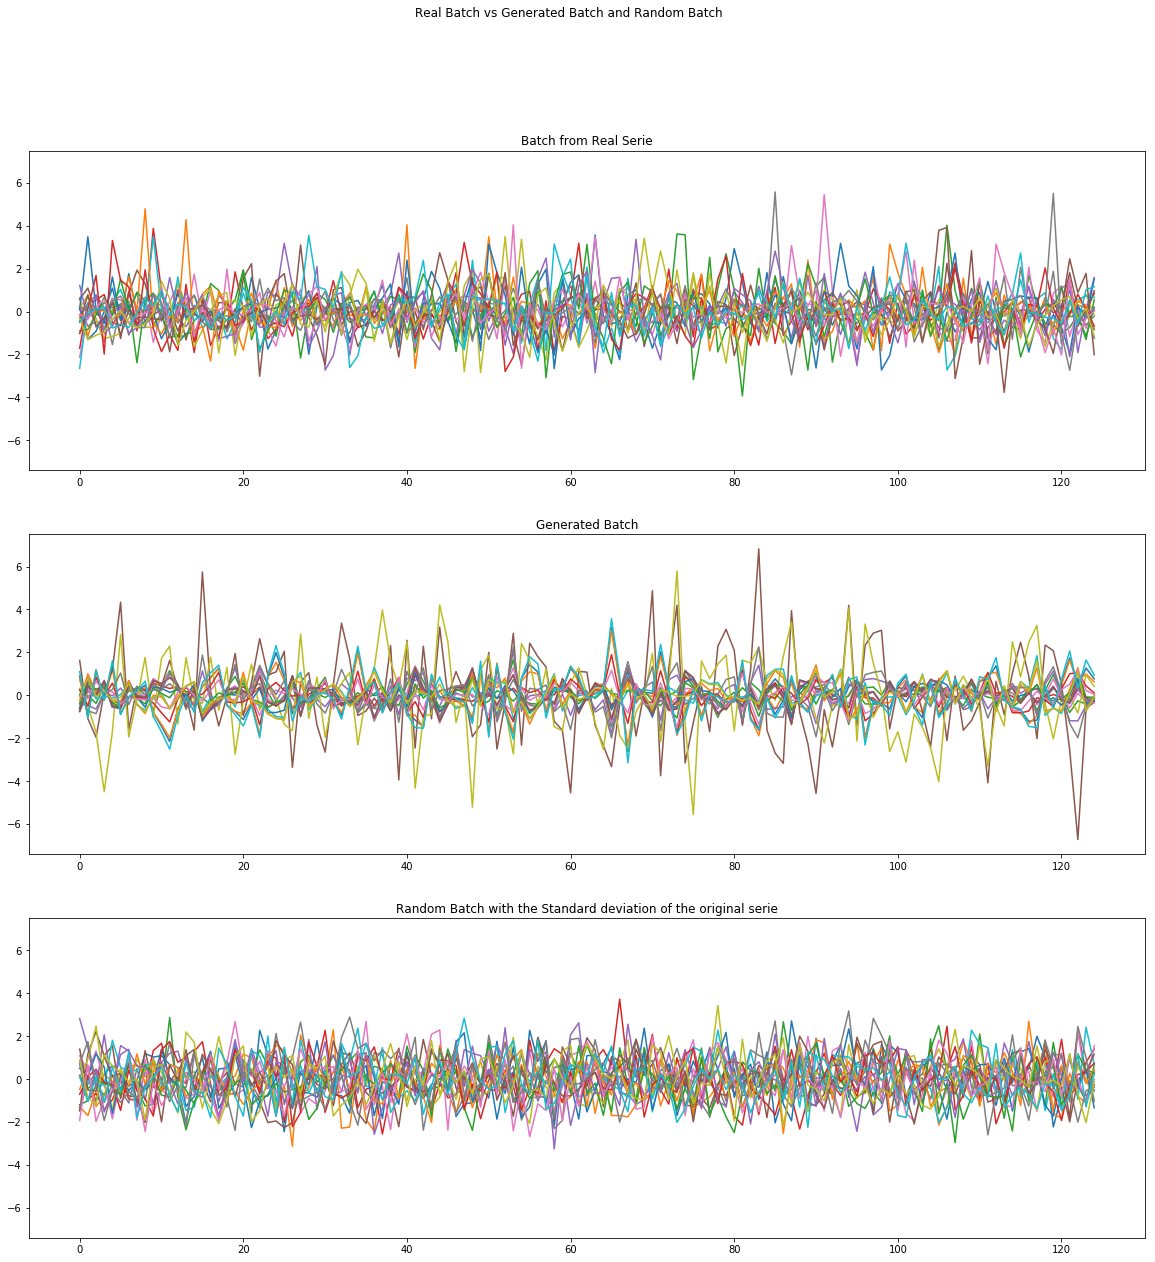

In [259]:
name_best = n1[order_125[1]]
utils.compare_plots(name_best, data, 20, 125, LG, LD)

{'serie': array([-0.05783672, -0.00076365,  0.02116481, ...,  0.03151451,
       -0.04869116, -0.05118388]), 'window': 250, 'frame': 20, 'frame_plot': 50, 'is_notebook': False, 'batchlen_plot': 100, 'Generator': <class 'DCGAN.Generator'>, 'Discriminator': <class 'DCGAN.Discriminator'>, 'N_ITER': 500, 'TRAIN_RATIO': 1, 'BATCHLEN': 30, 'generator_args': {'PRIOR_N': 20, 'PRIOR_STD': 20.0, 'WDTH': 200, 'DPTH': 3}, 'discriminator_args': {'WDTH': 50, 'DPTH': 1}, 'lr_G': 0.0001, 'betas_G': (0.5, 0.9), 'lr_D': 0.0001, 'betas_D': (0.5, 0.9), 'time_max': 600, 'save_model': True, 'save_name': 'Lin_G_274469792', 'plot': False}


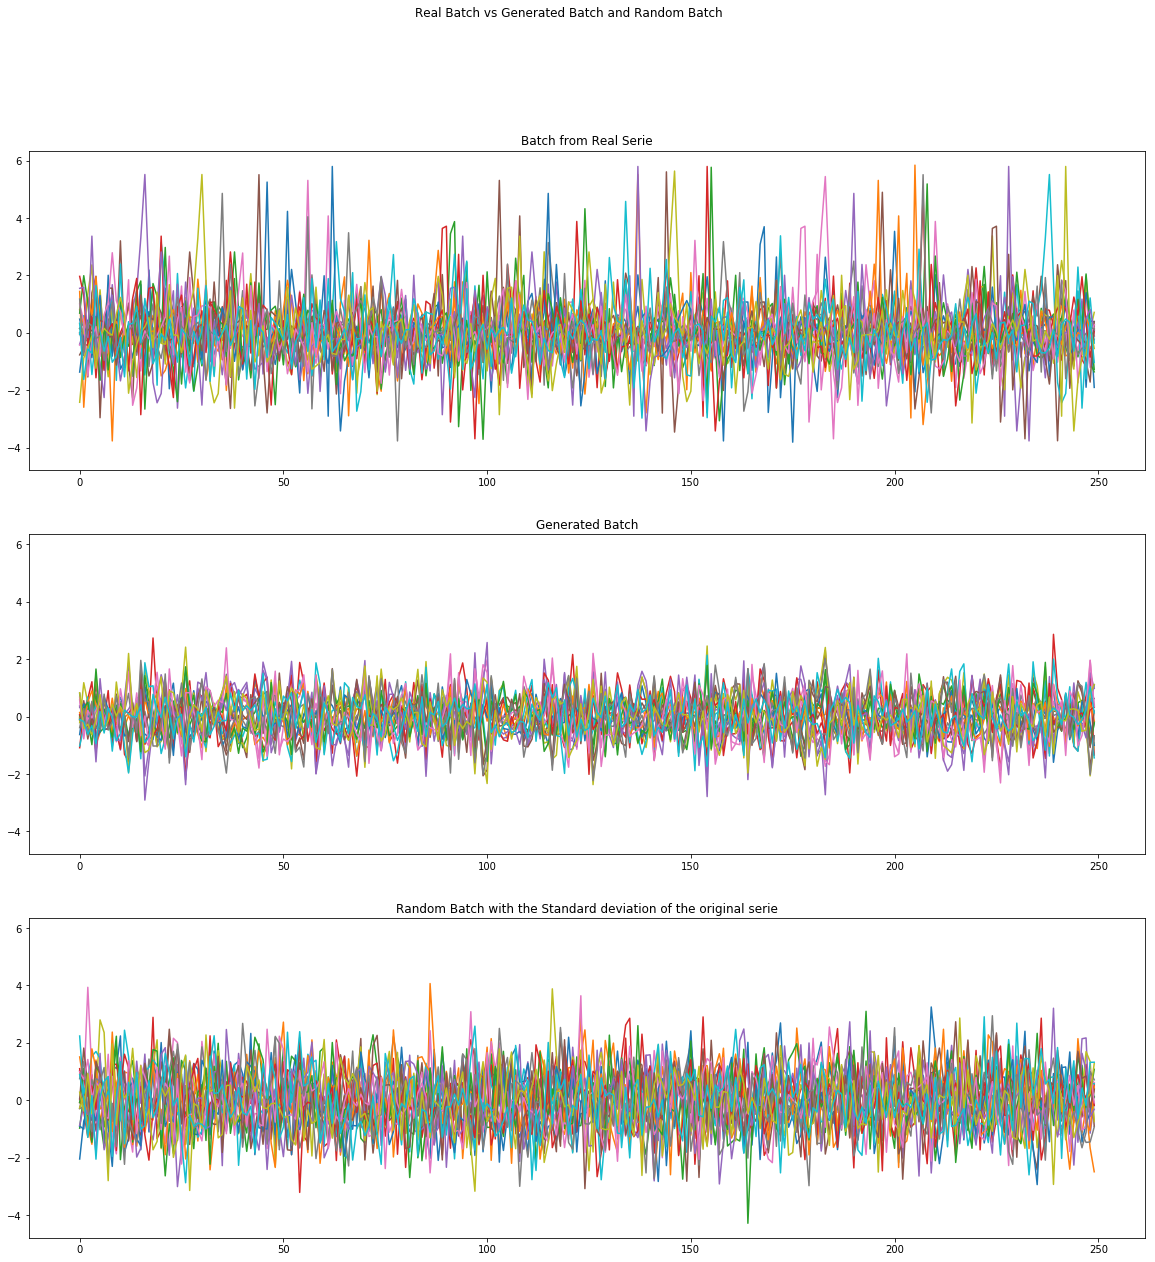

In [274]:
name_best = n2[order_250[11]]
utils.compare_plots(name_best, data, 20, 250, LG, LD)

In [216]:
df = pd.read_csv('VIX.csv', index_col=0, parse_dates=True, dayfirst=True)
df.iloc[:, 0] = df.iloc[:, 0].astype('float')
r = np.log(df).diff()[1:]
dt = [(df.index[t+1]-df.index[t]).days for t in range(r.shape[0])]
r = 1/np.array(dt) * r.iloc[:, 0]

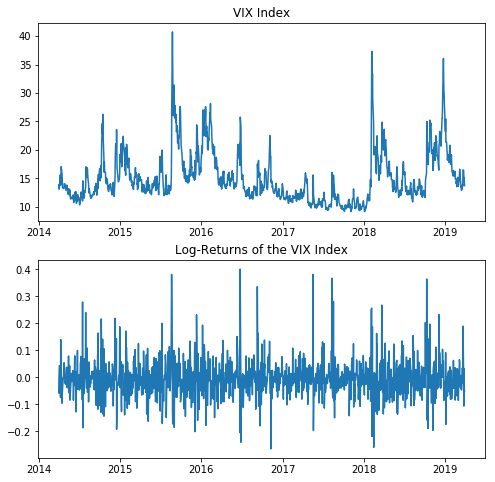

In [217]:
fig, ax = plt.subplots(2, figsize=(8, 8))
ax[0].plot(df)
ax[0].set_title('VIX Index')
ax[1].plot(r)
ax[1].set_title('Log-Returns of the VIX Index')
plt.savefig('VIX.png')
plt.show()